In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Install Required Libraries
!pip install transformers scikit-learn pandas torch

In [50]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

# Load LLM

In [51]:
# Load ClinicalBERT
model_name = "emilyalsentzer/Bio_ClinicalBERT"  # ClinicalBERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=48  # Placeholder for `num_labels`
)

# GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load File

In [52]:
# Load Pre-split Datasets
train_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM_o_train.csv"
val_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM_o_val.csv"
test_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM_o_test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

In [53]:
# Encode Disease Labels
label_encoder = LabelEncoder()
train_data['encoded_labels'] = label_encoder.fit_transform(train_data['disease_label'])
val_data['encoded_labels'] = label_encoder.transform(val_data['disease_label'])
test_data['encoded_labels'] = label_encoder.transform(test_data['disease_label'])

num_classes = len(label_encoder.classes_)

# Update BioBERT Model for Classification
model.num_labels = num_classes  # Update number of labels

# Tokenize Symptoms

In [54]:
# Tokenize Symptoms
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_texts(train_data['symptoms'])
val_encodings = tokenize_texts(val_data['symptoms'])
test_encodings = tokenize_texts(test_data['symptoms'])

# Convert labels to tensors
train_labels = torch.tensor(train_data['encoded_labels'].tolist())
val_labels = torch.tensor(val_data['encoded_labels'].tolist())
test_labels = torch.tensor(test_data['encoded_labels'].tolist())

# Dataset Class for Fine-Tuning
class SymptomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create PyTorch Datasets
train_dataset = SymptomDataset(train_encodings, train_labels)
val_dataset = SymptomDataset(val_encodings, val_labels)


# Fine-tuning BioBERT with LoRA

In [55]:
# Fine-Tuning BioBERT
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="steps",  # Enable logging after a fixed number of steps
    logging_steps= 10,  # Log training loss every 10 steps
    learning_rate= 8e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    num_train_epochs = 30,
    weight_decay=0.001,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [56]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.775000,2.503983
2,2.331400,2.133810
3,2.034300,1.871972
4,1.872900,1.775522
5,1.679700,1.669230
6,1.541500,1.615456
7,1.547300,1.535969
8,1.627000,1.472881
9,1.478800,1.423483
10,1.511600,1.441277


TrainOutput(global_step=3180, training_loss=1.435645467230359, metrics={'train_runtime': 232.6307, 'train_samples_per_second': 218.587, 'train_steps_per_second': 13.67, 'total_flos': 1202533705238400.0, 'train_loss': 1.435645467230359, 'epoch': 30.0})

# Generate ClinicalBERT Embedding for Random Forest

In [57]:
# Generate ClinicalBERT Embeddings
def generate_embeddings(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)
    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: batch[key].to(device) for key in ['input_ids', 'attention_mask']}
            outputs = model(**inputs)
            cls_embedding = outputs.logits.cpu().numpy()  # Extract logits for embedding
            embeddings.append(cls_embedding)
    return np.vstack(embeddings)

print("Generating embeddings for training data...")
train_embeddings = generate_embeddings(train_dataset)
print("Generating embeddings for validation data...")
val_embeddings = generate_embeddings(val_dataset)
print("Generating embeddings for testing data...")
test_embeddings = generate_embeddings(SymptomDataset(test_encodings, test_labels))

Generating embeddings for training data...
Generating embeddings for validation data...
Generating embeddings for testing data...


# UMAP (Uniform Manifold Approximation and Projection)

In [58]:
!pip install umap-learn

Reducing dimensions using UMAP...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


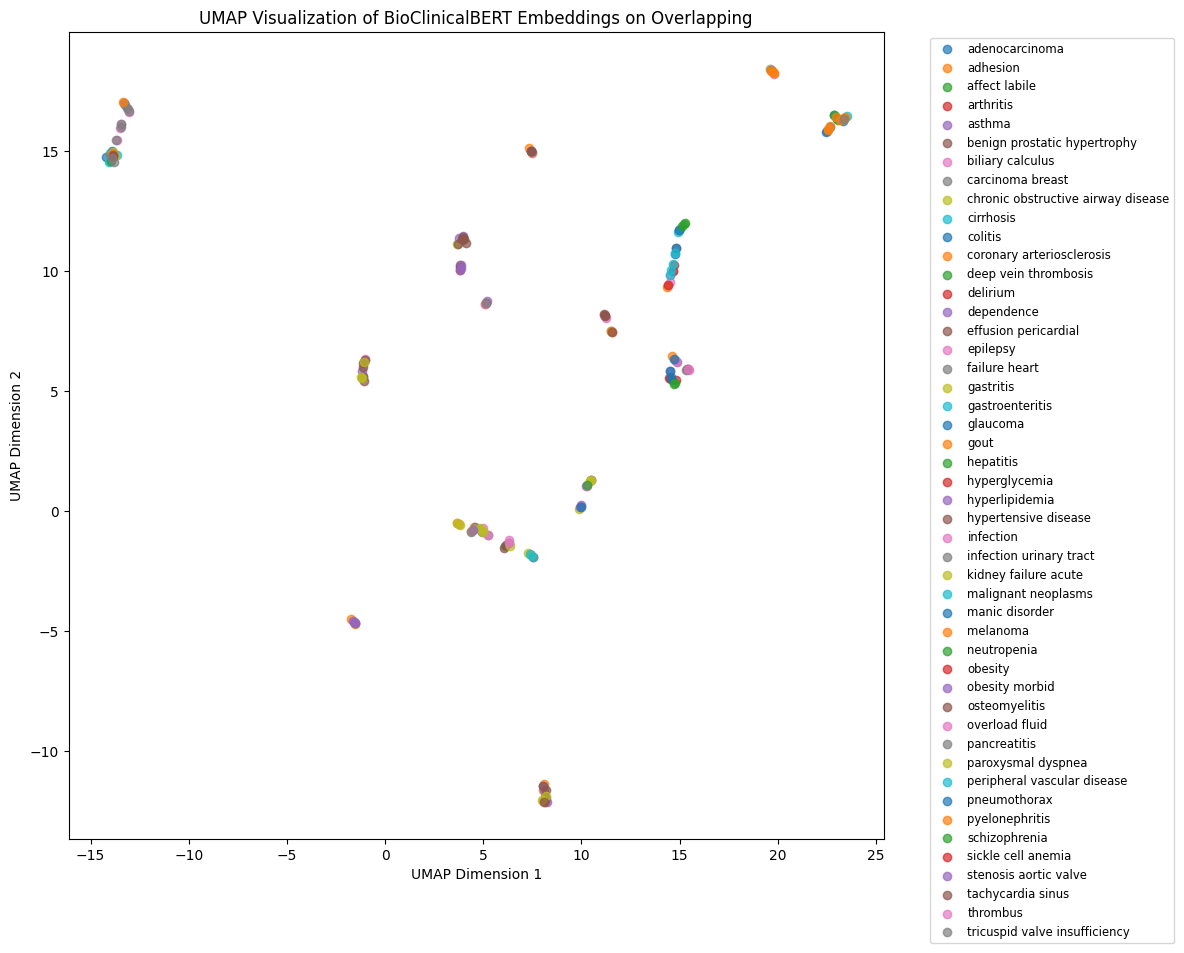

In [59]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# Generate test embeddings (ensure this is executed before using UMAP)
# test_embeddings should already be generated using your generate_embeddings function.

# Convert test labels to NumPy for easier handling
labels = test_labels.cpu().numpy()  # Ensure this is defined and matches the test dataset

# Reduce dimensions using UMAP
print("Reducing dimensions using UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(test_embeddings)

# Map numeric labels to disease names
disease_names = label_encoder.inverse_transform(labels)  # Map numeric labels to actual disease names

# Plot the 2D representation
plt.figure(figsize=(12, 10))
unique_labels = np.unique(disease_names)

for disease in unique_labels:
    indices = np.where(disease_names == disease)
    plt.scatter(
        reduced_embeddings[indices, 0], reduced_embeddings[indices, 1],
        label=disease, alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("UMAP Visualization of BioClinicalBERT Embeddings on Overlapping")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()


# Naive Bayes

In [66]:
# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))

Validation Report:
           adenocarcinoma  adhesion  affect labile  arthritis    asthma  \
precision        0.500000  1.000000       0.333333   0.400000  0.428571   
recall           1.000000  0.500000       1.000000   1.000000  1.000000   
f1-score         0.666667  0.666667       0.500000   0.571429  0.600000   
support          3.000000  2.000000       1.000000   2.000000  3.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                           0.0          0.500000               0.0   
recall                              0.0          0.083333               0.0   
f1-score                            0.0          0.142857               0.0   
support                             1.0         12.000000               2.0   

           chronic obstructive airway disease  cirrhosis  ...  pyelonephritis  \
precision                                 0.0   0.500000  ...        0.333333   
recall                                    0.0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [67]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/BioClinicalbert-nb-o-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/BioClinicalbert-nb-o-class.csv


# Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier
# Train Random Forest on Embeddings
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = rf_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = rf_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           adenocarcinoma  adhesion  affect labile  arthritis    asthma  \
precision        0.500000  1.000000            0.0   0.400000  0.500000   
recall           0.333333  0.500000            0.0   1.000000  0.666667   
f1-score         0.400000  0.666667            0.0   0.571429  0.571429   
support          3.000000  2.000000            1.0   2.000000  3.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                           0.0          0.428571               0.5   
recall                              0.0          0.500000               0.5   
f1-score                            0.0          0.461538               0.5   
support                             1.0         12.000000               2.0   

           chronic obstructive airway disease  cirrhosis  ...  pyelonephritis  \
precision                            0.333333   0.500000  ...        0.428571   
recall                               0.200000  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [69]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/BioClinicalbert-rf-o-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/BioClinicalbert-rf-o-class.csv


# Support Vector Classifier

In [70]:
# Train Naive Bayes on Embeddings
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))

Validation Report:
           adenocarcinoma  adhesion  affect labile  arthritis    asthma  \
precision        0.500000  1.000000       0.333333   0.400000  0.428571   
recall           1.000000  0.500000       1.000000   1.000000  1.000000   
f1-score         0.666667  0.666667       0.500000   0.571429  0.600000   
support          3.000000  2.000000       1.000000   2.000000  3.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                           0.0          0.500000               0.0   
recall                              0.0          0.083333               0.0   
f1-score                            0.0          0.142857               0.0   
support                             1.0         12.000000               2.0   

           chronic obstructive airway disease  cirrhosis  ...  pyelonephritis  \
precision                                 0.0   0.500000  ...        0.333333   
recall                                    0.0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [71]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/BioClinicalbert-svc-o-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/BioClinicalbert-svc-o-class.csv
